### Installations

In [ ]:
!pip install torch
!pip install sb3-contrib
!pip install stable_baselines
!pip install gym[box2d]==0.21.0
!pip install tqdm
# h5py.h5.H5PYConfig' has no attribute '__reduce_cython__'
# https://github.com/h5py/h5py/issues/1477#issuecomment-767677551

### Imports

In [2]:
import torch as th
import tensorflow as tf
import gym
import os

models_dir = "models/TRPO"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

from sb3_contrib import TRPO
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

print("Gym version: ",gym.__version__)
print("torch version: ",th.__version__)
print("tensorflow version: ",tf.__version__)
if(th.cuda.is_available()): 
    device = torch.device('cuda:0') 
    th.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

c:\Users\Love\anaconda3\envs\comp3340\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Love\anaconda3\envs\comp3340\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Love\anaconda3\envs\comp3340\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Love\anaconda3\envs\comp3340\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Gym version:  0.21.0
torch version:  1.13.0
tensorflow version:  2.3.0
Device set to : cpu


### Test The Gym Environment

In [3]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()
print("sample action: ", env.action_space.sample())
print("Obsevation space action: ", env.observation_space.shape)
print("sample observation: ", env.observation_space.sample())

sample action:  [-0.7927253   0.91237575]
Obsevation space action:  (8,)
sample observation:  [-0.3370009   0.2777667  -0.43803805  0.7931137   2.0797458  -0.51982474
  0.4500485  -1.6469542 ]


### Train And Save the Agent

In [10]:
num_features = 64
num_layers = 3
episodes = 1000
act_f = th.nn.ReLU
# Custom actor (pi) and value function (vf) networks
# Custom MLP policy of three layers of size 128 each
policy_kwargs = dict(activation_fn=act_f,
                     net_arch=[dict(pi=[num_features]*num_layers, vf=[num_features]*num_layers)]) 

env = gym.make('LunarLanderContinuous-v2')
model = TRPO('MlpPolicy', env, policy_kwargs=policy_kwargs, gamma=0.99, target_kl=0.01, batch_size=64, learning_rate=0.001)


model_name = "trpo_{}F_{}L_{}Episo_{}BatchS_{}γ_{}LearnR_{}TargetKL_{}".format(num_features,num_layers, 
                                                                               episodes,model.batch_size,
                                                                               model.gamma,model.learning_rate,
                                                                               model.target_kl,act_f.__name__)
reward_per_episode = []
for episode in trange(episodes):
    model = model.learn(total_timesteps=1000, reset_num_timesteps=False, log_interval=100)
    #save model every total_timesteps steps
    # model.save(f"{models_dir}/{TIMPSTEPS * episode}")
    model.save(f"{models_dir}/{model_name}")
    state = env.reset()
    total_reward, total_step = 0, 0
    while True:
        action, _state = model.predict(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        total_step += 1
        if done:
            env.reset()
            reward_per_episode.append(total_reward)
            break

  0%|          | 1/1000 [00:02<35:54,  2.16s/it]

: 

: 

### Result

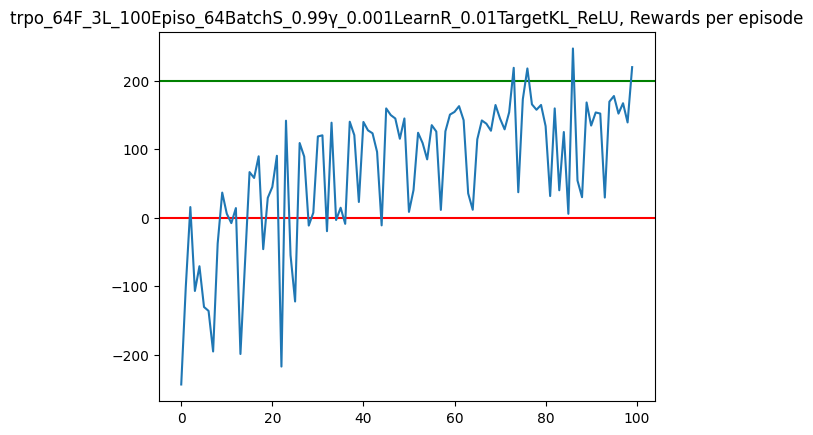

In [5]:
plt.axhline(y = 200, color = 'g', linestyle = '-')
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.plot(reward_per_episode)
plt.title("{}, Rewards per episode".format(model_name))
plt.show()

### Test The Trained Model

In [127]:
#Delete the model just trainned if u want to load another model in saved files
del model

In [9]:
model_name = "trpo_64F_3L_100Episo_64BatchS_0.99γ_0.001LearnR_0.01TargetKL_ReLU"
model = TRPO.load(f"{models_dir}/{model_name}")

state = env.reset()
reward_per_episode = []
steps_per_episode = []
for episode in trange(10):
    total_reward, total_step = 0, 0
    while True:
        env.render()
        action, _state = model.predict(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        total_step += 1
        if done:
            env.reset()
            reward_per_episode.append(total_reward)
            steps_per_episode.append(total_step)
            break
env.close()

 40%|████      | 4/10 [00:38<00:57,  9.55s/it]


KeyboardInterrupt: 

### Results

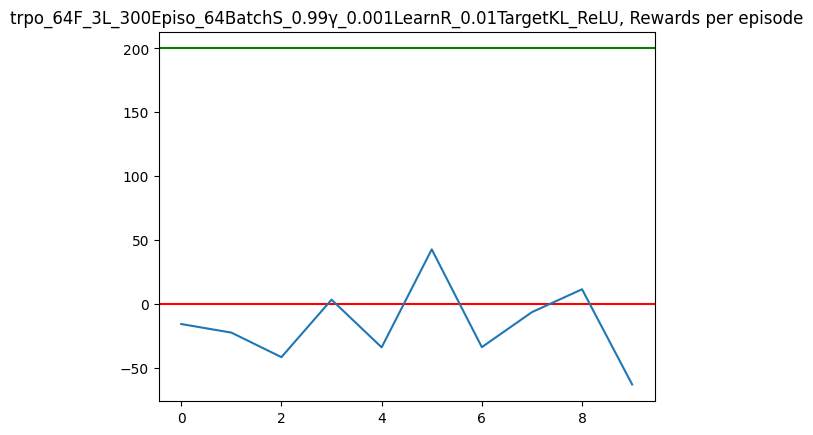

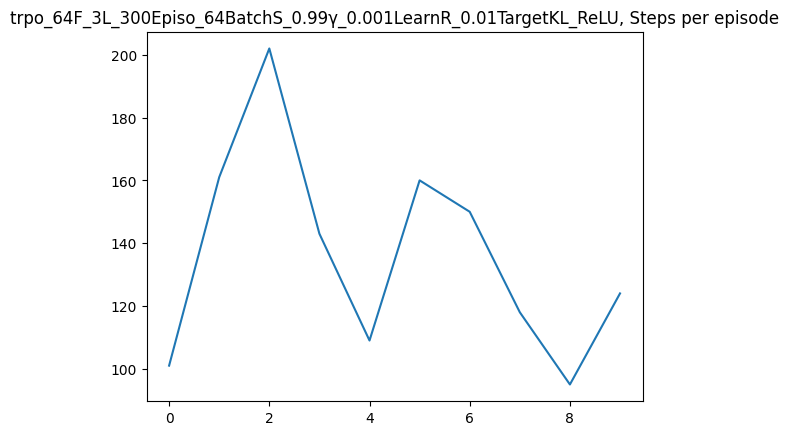

In [8]:
plt.axhline(y = 200, color = 'g', linestyle = '-')
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.plot(reward_per_episode)
plt.title("{}, Rewards per episode".format(model_name))
plt.show()

plt.plot(steps_per_episode)
plt.title("{}, Steps per episode".format(model_name))
plt.show()

In [27]:
converge_reward = 250
converge_count = 0
converge_count_per_episo = []
total_reward = 0
env.reset()     
while True:
    action, _state = model.predict(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    total_reward += reward
    if done:
        if total_reward >= converge_reward:
            converge_count+=1
        else:
            converge_count=0
        converge_count_per_episo.append(converge_count)
        total_reward = 0
        env.reset()
    if converge_count >= 5:
        break 

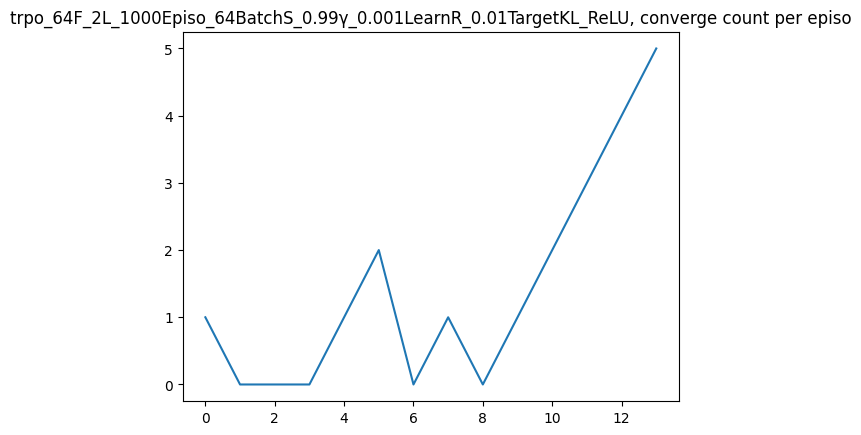

In [28]:
plt.plot(converge_count_per_episo)
plt.title("{}, converge count per episo".format(model_name))
plt.show()